In [2]:
import pandas as pd 
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

# Define tickers and time range

In [8]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']


In [30]:
years = 10
end_date = datetime.today()
start_date = end_date - timedelta(days= years*365) 

# Download data from yahoo finance

In [31]:
close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    close_df[ticker] = data['Close']
 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Display the Tickers dataframe

In [32]:
print(close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2015-05-01  177.294159  62.580376  113.080002  101.001091   91.783157
2015-05-04  177.799026  62.489315  114.099998  101.167816   92.103455
2015-05-05  175.762878  62.390705  114.419998   99.519142   91.007759
2015-05-06  175.039383  62.216263  114.360001   98.833786   90.754906
2015-05-07  175.737686  62.345181  113.419998   99.426575   91.100471
...                ...        ...         ...         ...         ...
2025-04-21  513.880005  72.250000  315.589996  433.109985  252.600006
2025-04-22  527.250000  72.379997  311.109985  444.480011  259.029999
2025-04-23  535.419983  72.529999  303.649994  454.559998  263.440002
2025-04-24  546.690002  72.940002  308.070007  467.350006  268.989990
2025-04-25  550.640015  73.180000  304.730011  472.559998  270.640015

[2512 rows x 5 columns]


# Calculate log normal returns

In [33]:
log_returns = np.log(close_df/close_df.shift(1))
log_returns = log_returns.dropna()

# Calculate covariance matrix

In [34]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.033557  0.001161  0.001524  0.038674  0.034059
BND  0.001161  0.003030  0.002708  0.001455  0.001250
GLD  0.001524  0.002708  0.020227  0.002180  0.001634
QQQ  0.038674  0.001455  0.002180  0.051114  0.039192
VTI  0.034059  0.001250  0.001634  0.039192  0.034838


# Define Portfolio Metrics

In [35]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

# Set risk free rate

In [17]:
risk_free_rate = 0.02

# Define function to minimize negative Sharpe Ratio
This is because scipy doesn't have a maximize function

In [18]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

# Set constraints and bounds
The constraints variable is a dict with 2 keys: 'type' and 'fun'. 'type' is set to 'eq', which means equality constraint, and 'fun' is assigned the function check_sum, which checks if the sum of the portfolio weights equals to 1

In [36]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.3) for _ in range(len(tickers))]

# Set initial weights 

In [37]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


# Optimize the weights to maximize sharpe ratio
'SLSQP' stands for Sequential Least Squares Quadratic Programming, which is suitable for solving nonlinear optimization problems with constraints

In [38]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

optimal_weights = optimized_results.x

print('Optimial Weights:')
for ticker, weight in zip(tickers, optimal_weights):
    print(f'{ticker}: {weight:.2f}')

print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f'Expected Annual Return: {optimal_portfolio_return:.2f}')
print(f'Expected Volatility: {optimal_portfolio_volatility:.2f}')
print(f'Sharpe Ratio: {optimal_sharpe_ratio:.4f}')


Optimial Weights:
SPY: 0.16
BND: 0.24
GLD: 0.30
QQQ: 0.30
VTI: 0.00

Expected Annual Return: 0.10
Expected Volatility: 0.11
Sharpe Ratio: 0.7030


# Plot the portfolio

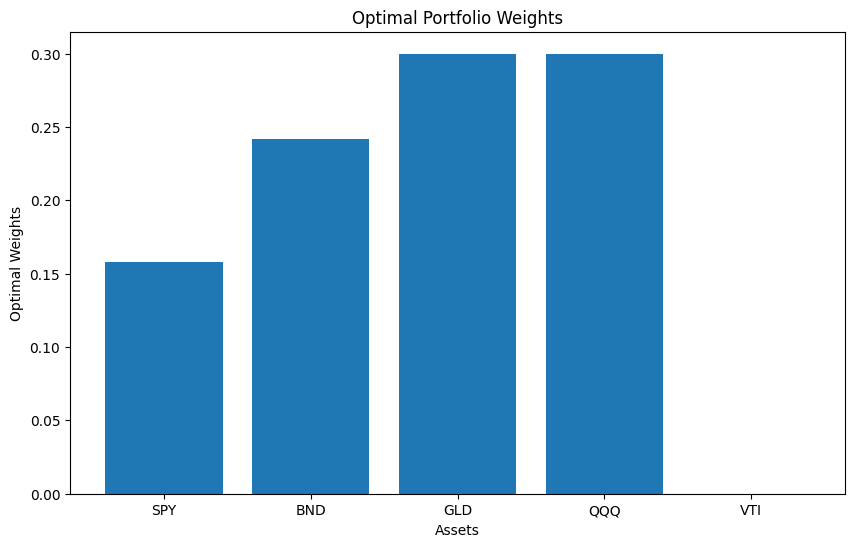

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()